In [1]:
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 2.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import numba
import gc, time
import pickle
import numpy as np
from tensorflow.keras.datasets import mnist, fashion_mnist
from skimage.util import view_as_windows
from skimage.measure import block_reduce
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

np.random.seed(1)
warnings.filterwarnings("ignore")

In [3]:
@numba.jit(nopython = True, parallel = True)
def pca_cal(X: np.ndarray):
    cov = X.transpose() @ X
    eva, eve = np.linalg.eigh(cov)
    inds = eva.argsort()[::-1]
    eva = eva[inds]
    kernels = eve.transpose()[inds]
    return kernels, eva / (X.shape[0] - 1)

@numba.jit(forceobj = True, parallel = True)
def remove_mean(X: np.ndarray, feature_mean: np.ndarray):
    return X - feature_mean

@numba.jit(nopython = True, parallel = True)
def feat_transform(X: np.ndarray, kernel: np.ndarray):
    return X @ kernel.transpose()

class Saab():
    def __init__(self, num_kernels=-1, needBias=True, bias=0):
        self.num_kernels = num_kernels
        self.needBias = needBias
        self.Bias_previous = bias # bias calculated from previous
        self.Bias_current = [] # bias for the current Hop
        self.Kernels = []
        self.Mean0 = [] # feature mean of AC
        self.Energy = [] # kernel energy list
        self.trained = False

    def fit(self, X):
        assert (len(X.shape) == 2), "Input must be a 2D array!"
        X = X.astype('float32')

        # add bias from the previous Hop
        if self.needBias == True:
            X += self.Bias_previous

        # remove DC, get AC components
        dc = np.mean(X, axis = 1, keepdims = True)
        X = remove_mean(X, dc)

        # calcualte bias at the current Hop
        self.Bias_current = np.max(np.linalg.norm(X, axis=1))

        # remove feature mean --> self.Mean0
        self.Mean0 = np.mean(X, axis = 0, keepdims = True)
        X = remove_mean(X, self.Mean0)

        if self.num_kernels == -1:
            self.num_kernels = X.shape[-1]

        # Rewritten PCA Using Numpy
        kernels, eva = pca_cal(X)

        # Concatenate with DC kernel
        dc_kernel = 1 / np.sqrt(X.shape[-1]) * np.ones((1, X.shape[-1]))# / np.sqrt(largest_ev)
        kernels = np.concatenate((dc_kernel, kernels[:-1]), axis = 0)

        # Concatenate with DC energy
        largest_ev = np.var(dc * np.sqrt(X.shape[-1]))
        energy = np.concatenate((np.array([largest_ev]), eva[:-1]), axis = 0)
        energy = energy / np.sum(energy)

        # store
        self.Kernels, self.Energy = kernels.astype('float32'), energy
        self.trained = True


    def transform(self, X):
        assert (self.trained == True), "Must call fit first!"
        X = X.astype('float32')

        # add bias from the previous Hop
        if self.needBias == True:
            X += self.Bias_previous

        # remove feature mean of AC
        X = remove_mean(X, self.Mean0)

        # convolve with DC and AC filters
        X = feat_transform(X, self.Kernels)

        return X

In [4]:
def gc_invoker(func):
    def wrapper(*args, **kw):
        value = func(*args, **kw)
        gc.collect()
        time.sleep(0.5)
        return value
    return wrapper

class cwSaab():
    def __init__(self, depth=1, TH1=0.01, TH2=0.005, SaabArgs=None, shrinkArgs=None, load=False):
        self.trained = False
        self.split = False

        if load == False:
            assert (depth > 0), "'depth' must > 0!"
            assert (SaabArgs != None), "Need parameter 'SaabArgs'!"
            assert (shrinkArgs != None), "Need parameter 'shrinkArgs'!"
            self.depth = (int)(depth)
            self.shrinkArgs = shrinkArgs
            self.SaabArgs = SaabArgs
            self.par = {}
            self.bias = {}
            self.TH1 = TH1
            self.TH2 = TH2
            self.Energy = {}

            if depth > np.min([len(SaabArgs), len(shrinkArgs)]):
                self.depth = np.min([len(SaabArgs), len(shrinkArgs)])
                print("       <WARNING> Too few 'SaabArgs/shrinkArgs' to get depth %s, actual depth: %s"%(str(depth),str(self.depth)))

    @gc_invoker
    def SaabTransform(self, X, saab, layer, train=False):
        '''
        Get saab features.
        If train==True, remove leaf nodes using TH1, only leave the intermediate node's response
        '''
        shrinkArg, SaabArg = self.shrinkArgs[layer], self.SaabArgs[layer]
        assert ('func' in shrinkArg.keys()), "shrinkArg must contain key 'func'!"
        X = shrinkArg['func'](X, shrinkArg)
        S = list(X.shape)
        X = X.reshape(-1, S[-1])

        if SaabArg['num_AC_kernels'] != -1:
            S[-1] = SaabArg['num_AC_kernels']

        transformed = saab.transform(X)
        transformed = transformed.reshape(S[0],S[1],S[2],-1)

        if train==True and self.SaabArgs[layer]['cw'] == True: # remove leaf nodes
            transformed = transformed[:, :, :, saab.Energy>self.TH1]

        return transformed

    @gc_invoker
    def SaabFit(self, X, layer, bias=0):
        '''Learn a saab model'''
        shrinkArg, SaabArg = self.shrinkArgs[layer], self.SaabArgs[layer]
        assert ('func' in shrinkArg.keys()), "shrinkArg must contain key 'func'!"
        X = shrinkArg['func'](X, shrinkArg)
        S = list(X.shape)
        X = X.reshape(-1, S[-1])
        saab = Saab(num_kernels=SaabArg['num_AC_kernels'], needBias=SaabArg['needBias'], bias=bias)
        saab.fit(X)
        return saab

    @gc_invoker
    def discard_nodes(self, saab):
        '''Remove discarded nodes (<TH2) from the model'''
        energy_k = saab.Energy
        discard_idx = np.argwhere(energy_k<self.TH2)
        saab.Kernels = np.delete(saab.Kernels, discard_idx, axis=0)
        saab.Energy = np.delete(saab.Energy, discard_idx)
        saab.num_kernels -= discard_idx.size
        return saab

    @gc_invoker
    def cwSaab_1_layer(self, X, train, bias=None):
        '''cwsaab/saab transform starting for Hop-1'''
        if train == True:
            saab_cur = []
            bias_cur = []
        else:
            saab_cur = self.par['Layer'+str(0)]
            bias_cur = self.bias['Layer'+str(0)]
        transformed, eng = [], []

        if self.SaabArgs[0]['cw'] == True: # channel-wise saab
            S = list(X.shape)
            S[-1] = 1
            X = np.moveaxis(X, -1, 0)
            for i in range(X.shape[0]):
                X_tmp = X[i].reshape(S)
                if train == True:
                    # fit
                    saab = self.SaabFit(X_tmp, layer=0)
                    # remove discarded nodes
                    saab = self.discard_nodes(saab)
                    # store
                    saab_cur.append(saab)
                    bias_cur.append(saab.Bias_current)
                    eng.append(saab.Energy)
                    # transformed feature
                    transformed.append(self.SaabTransform(X_tmp, saab=saab, layer=0, train=True))
                else:
                    if len(saab_cur) == i:
                        break
                    transformed.append(self.SaabTransform(X_tmp, saab=saab_cur[i], layer=0))
            transformed = np.concatenate(transformed, axis=-1)
        else: # saab, not channel-wise
            if train == True:
                saab = self.SaabFit(X, layer=0)
                saab = self.discard_nodes(saab)
                saab_cur.append(saab)
                bias_cur.append(saab.Bias_current)
                eng.append(saab.Energy)
                transformed = self.SaabTransform(X, saab=saab, layer=0, train=True)
            else:
                transformed = self.SaabTransform(X, saab=saab_cur[0], layer=0)

        if train == True:
            self.par['Layer0'] = saab_cur
            self.bias['Layer'+str(0)] = bias_cur
            self.Energy['Layer0'] = eng

        return transformed

    @gc_invoker
    def cwSaab_n_layer(self, X, train, layer):
        '''cwsaab/saab transform starting from Hop-2'''
        output, eng_cur, ct, pidx = [], [], -1, 0
        S = list(X.shape)
        saab_prev = self.par['Layer'+str(layer-1)]
        bias_prev = self.bias['Layer'+str(layer-1)]

        if train == True:
            saab_cur = []
            bias_cur = []
        else:
            saab_cur = self.par['Layer'+str(layer)]

        if self.SaabArgs[layer]['cw'] == True: # channel-wise saab
            S[-1] = 1
            X = np.moveaxis(X, -1, 0)
            for i in range(len(saab_prev)):
                for j in range(saab_prev[i].Energy.shape[0]):
                    if train==False:
                        ct += 1 # helping index
                    if saab_prev[i].Energy[j] < self.TH1: # this is a leaf node
                        continue
                    else: # this is an intermediate node
                        if train==True:
                            ct += 1

                    self.split = True
                    X_tmp = X[ct].reshape(S)

                    if train == True:
                        # fit
                        saab = self.SaabFit(X_tmp, layer=layer, bias=bias_prev[i])
                        # children node's energy should be multiplied by the parent's energy
                        saab.Energy *= saab_prev[i].Energy[j]
                        # remove the discarded nodes
                        saab = self.discard_nodes(saab)
                        # store
                        saab_cur.append(saab)
                        bias_cur.append(saab.Bias_current)
                        eng_cur.append(saab.Energy)
                        # get output features
                        out_tmp = self.SaabTransform(X_tmp, saab=saab, layer=layer, train=True)
                    else:
                        out_tmp = self.SaabTransform(X_tmp, saab=saab_cur[pidx], layer=layer)
                        pidx += 1 # helping index

                    output.append(out_tmp)

                    # Clean the Cache
                    X_tmp = None
                    gc.collect()
                    out_tmp = None
                    gc.collect()

            output = np.concatenate(output, axis=-1)

        else: # saab, not channel-wise
            if train == True:
                # fit
                saab = self.SaabFit(X, layer=layer, bias=bias_prev[0])
                # remove the discarded nodes
                saab = self.discard_nodes(saab)
                # store
                saab_cur.append(saab)
                bias_cur.append(saab.Bias_current)
                eng_cur.append(saab.Energy)
                # get output features
                output = self.SaabTransform(X, saab=saab, layer=layer, train=True)
            else:
                output = self.SaabTransform(X, saab=saab_cur[0], layer=layer)

        if train == True:
            if self.split == True or self.SaabArgs[0]['cw'] == False:
                self.par['Layer'+str(layer)] = saab_cur
                self.bias['Layer'+str(layer)] = bias_cur
                self.Energy['Layer'+str(layer)] = eng_cur

        return output

    def fit(self, X):
        '''train and learn cwsaab/saab kernels'''
        X = self.cwSaab_1_layer(X, train=True)
        print('=' * 45 + '>c/w Saab Train Hop 1')
        for i in range(1, self.depth):
            X = self.cwSaab_n_layer(X, train = True, layer = i)
            if (self.split == False and self.SaabArgs[i]['cw'] == True):
                self.depth = i
                print("       <WARNING> Cannot futher split, actual depth: %s"%str(i))
                break
            print('=' * 45 + f'>c/w Saab Train Hop {i+1}')
            self.split = False
        self.trained = True

    def transform(self, X):
        '''
        Get feature for all the Hops
        Parameters
        ----------
        X: Input image (N, H, W, C), C=1 for grayscale, C=3 for color image
        Returns
        -------
        output: a list of transformed feature maps
        '''
        assert (self.trained == True), "Must call fit first!"
        output = []
        X = self.cwSaab_1_layer(X, train = False)
        output.append(X)

        for i in range(1, self.depth):
            X = self.cwSaab_n_layer(X, train=False, layer=i)
            output.append(X)

        return output

    def transform_singleHop(self, X, layer=0):
        '''
        Get feature for a single Hop

        Parameters
        ----------
        X: previous Hops output (N, H1, W1, C1)
        layer: Hop index (start with 0)

        Returns
        -------
        output: transformed feature maps (N, H2, W2, C2)
        '''
        assert (self.trained == True), "Must call fit first!"
        if layer==0:
            output = self.cwSaab_1_layer(X, train = False)
        else:
            output = self.cwSaab_n_layer(X, train=False, layer=layer)

        return output

In [5]:
class PixelHop(cwSaab):
    def __init__(self, depth=1, TH1=0.005, TH2=0.001, SaabArgs=None, shrinkArgs=None, concatArg=None, load=False):
        super().__init__(depth=depth, TH1=TH1, TH2=TH2, SaabArgs=SaabArgs, shrinkArgs=shrinkArgs, load=load)
        self.TH1 = TH1
        self.TH2 = TH2
        self.idx = []
        self.concatArg = concatArg

    def fit(self, X):
        super().fit(X)
        return self

    def transform(self, X):
        X = super().transform(X)
        return self.concatArg['func'](X, self.concatArg)

    def transform_singleHop(self, X, layer=0):
        X = super().transform_singleHop(X, layer=layer)
        return X

    '''Methods for Saving & Loading'''
    def save(self, filename: str):
        assert (self.trained == True), "Need to Train First"
        pixelhop_model = {}
        pixelhop_model['par'] = self.par
        pixelhop_model['bias'] = self.bias
        pixelhop_model['depth'] = self.depth
        pixelhop_model['energy'] = self.Energy
        pixelhop_model['SaabArgs'] = self.SaabArgs
        pixelhop_model['shrinkArgs'] = self.shrinkArgs
        pixelhop_model['concatArgs'] = self.concatArg
        pixelhop_model['TH1'] = self.TH1
        pixelhop_model['TH2'] = self.TH2

        with open(filename + '.pkl','wb') as f:
            pickle.dump(pixelhop_model, f)
        return

    def load(self, filename: str):
        pixelhop_model = pickle.load(open(filename + '.pkl','rb'))
        self.par = pixelhop_model['par']
        self.bias = pixelhop_model['bias']
        self.depth = pixelhop_model['depth']
        self.Energy = pixelhop_model['energy']
        self.SaabArgs = pixelhop_model['SaabArgs']
        self.shrinkArgs = pixelhop_model['shrinkArgs']
        self.concatArg = pixelhop_model['concatArgs']
        self.trained = True
        self.TH1 = pixelhop_model['TH1']
        self.TH2 = pixelhop_model['TH2']

        return self

In [6]:
# Preprocess
N_Train_Reduced = 10000    # 10000
N_Train_Full = 60000     # 50000
N_Test = 10000            # 10000

BS = 2000  # batch size

In [7]:
def shuffle_data(X, y):
    shuffle_idx = np.random.permutation(y.size)
    X = X[shuffle_idx]
    y = y[shuffle_idx]
    return X, y

In [8]:
def select_balanced_subset(images, labels, use_num_images):
    '''
    select equal number of images from each classes
    '''
    num_total, H, W, C = images.shape
    num_class = np.unique(labels).size
    num_per_class = int(use_num_images / num_class)

    # Shuffle
    images, labels = shuffle_data(images, labels)

    selected_images = np.zeros((use_num_images, H, W, C))
    selected_labels = np.zeros(use_num_images)

    for i in range(num_class):
        selected_images[i * num_per_class:(i + 1) *
                        num_per_class] = images[labels == i][:num_per_class]
        selected_labels[i * num_per_class:(i + 1) *
                        num_per_class] = np.ones((num_per_class)) * i

    # Shuffle again
    selected_images, selected_labels = shuffle_data(
        selected_images, selected_labels)

    return selected_images, selected_labels

In [9]:
def Shrink(X, shrinkArg):
    # ---- max pooling----
    pool = shrinkArg['pool']

    if pool > 1:
        X = block_reduce(X, (1, pool, pool, 1), np.max)

    # ---- neighborhood construction
    win = shrinkArg['win']
    stride = shrinkArg['stride']
    pad = shrinkArg['pad']
    ch = X.shape[-1]

    if pad > 0:
        X = np.pad(X, ((0, 0), (pad, pad), (pad, pad), (0, 0)), 'reflect')

    X = view_as_windows(X, (1, win, win, ch), (1, stride, stride, ch))

    return X.reshape(X.shape[0], X.shape[1], X.shape[2], -1)

In [10]:
def Concat(X, concatArg):
    return X

In [11]:
def get_feat(pixelHopModel, X, num_layers=3):
    output = pixelHopModel.transform_singleHop(X, layer=0)
    if num_layers > 1:
        for i in range(num_layers-1):
            output = pixelHopModel.transform_singleHop(output, layer=i+1)
    return output

In [12]:
def obtain_data(dataset='MNIST'):
    # ---------- Load data and split ----------
    if dataset == 'MNIST':
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
    else:
        (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

    # -----------Data Preprocessing-----------
    x_train = np.asarray(x_train, dtype='float32')[:, :, :, np.newaxis]
    x_test = np.asarray(x_test, dtype='float32')[:, :, :, np.newaxis]
    y_train = np.asarray(y_train, dtype='int')
    y_test = np.asarray(y_test, dtype='int')

    # if use only 10000 images train pixelhop
    # x_train_reduced, y_train_reduced = select_balanced_subset(
    #     x_train, y_train, use_num_images=N_Train_Reduced)

    x_train /= 255.0
    x_test /= 255.0

    return (x_train, y_train, x_test, y_test)

In [13]:
def obtain_pixel_hop_args(isPixelHopPlusPlus=True):
    SaabArgs = [
        {'num_AC_kernels': -1, 'needBias': False, 'cw': False},
        {'num_AC_kernels': -1, 'needBias': True, 'cw': isPixelHopPlusPlus},
        {'num_AC_kernels': -1, 'needBias': True, 'cw': isPixelHopPlusPlus}
    ]

    shrinkArgs = [
        {'func': Shrink, 'win': 5, 'stride': 1, 'pad': 2, 'pool': 1},
        {'func': Shrink, 'win': 5, 'stride': 1, 'pad': 0, 'pool': 2},
        {'func': Shrink, 'win': 5, 'stride': 1, 'pad': 0, 'pool': 2},
    ]

    concatArg = {'func': Concat}

    return SaabArgs, shrinkArgs, concatArg

In [14]:
def train_pixel_hop(dataset='MNIST', isPixelHopPlusPlus=True, TH1=0.005, TH2=0.001):
    SaabArgs, shrinkArgs, concatArg = obtain_pixel_hop_args(isPixelHopPlusPlus)
    x_train, y_train, x_test, y_test = obtain_data(dataset)

    pixelHopModel = PixelHop(depth=3, TH1=TH1, TH2=TH2, SaabArgs=SaabArgs, shrinkArgs=shrinkArgs, concatArg=concatArg)
    pixelHopModel.fit(x_train)

    return pixelHopModel, x_train, y_train, x_test, y_test

In [15]:
def get_model_size(pixelHopModel, x_train):
    hop1 = get_feat(pixelHopModel, x_train, 0)
    hop2 = get_feat(pixelHopModel, x_train, 2)
    hop3 = get_feat(pixelHopModel, x_train, 3)

    k1 = hop1.shape[-1]
    k2 = hop2.shape[-1]
    k3 = hop3.shape[-1]

    return k1, k2, k3

In [16]:
def get_model_features(pixelHopModel, x_train, x_test):
    train_hop3_feats = get_feat(pixelHopModel, x_train, 3)
    test_hop3_feats = get_feat(pixelHopModel, x_test, 3)

    STD = np.std(train_hop3_feats, axis=0, keepdims=1)
    train_hop3_feats = train_hop3_feats/STD
    test_hop3_feats = test_hop3_feats/STD

    return train_hop3_feats, test_hop3_feats

In [17]:
def train_xgboost(train_feat, train_labels):
    clf = xgb.XGBClassifier(
        n_jobs=-1,
        objective='multi:softprob',
        # tree_method='gpu_hist', gpu_id=None,
        max_depth=6, n_estimators=100,
        min_child_weight=5, gamma=5,
        subsample=0.8, learning_rate=0.1,
        nthread=8, colsample_bytree=1.0
    )
    clf.fit(train_feat, train_labels)

    return clf

In [18]:
def train(dataset='MNIST', isPixelHopPlusPlus=True, TH1=0.005, TH2=0.001, model_size=False):
    start = time.time()
    pixelhopModel, x_train, y_train, x_test, y_test = train_pixel_hop(dataset=dataset, isPixelHopPlusPlus=isPixelHopPlusPlus, TH1=TH1, TH2=TH2)
    train_features, test_features = get_model_features(pixelhopModel, x_train=x_train, x_test=x_test)
    end = time.time()

    training_time = end - start

    pixelhop_parameters_size = None

    if model_size:
        pixelhop_parameters_size = get_model_size(pixelhopModel, x_train=x_train)

    clf = train_xgboost(np.squeeze(train_features), y_train)

    train_acc = clf.score(np.squeeze(train_features), y_train)

    test_acc = clf.score(np.squeeze(test_features), y_test)

    return pixelhop_parameters_size, clf, x_test, test_features, y_test, training_time, train_acc, test_acc

In [19]:
def find_confused_pairs(clf, test_data, test_features, labels, class_names=[i for i in range(10)]):
    y_test = labels
    y_pred = clf.predict(np.squeeze(test_features))

    cm = confusion_matrix(y_test, y_pred)
    cm = cm.tolist()

    pairs = []
    for i in range(10):
        for j in range(10):
            if i != j:
                pairs.append((cm[i][j], i, j))

    confused_pairs = sorted(pairs, key=lambda x: x[0], reverse=True)

    confused_pairs = confused_pairs[:2]

    image_samples = []
    for _, true_label, pred_label in confused_pairs:
        for i in range(len(labels)):
            if labels[i] == true_label and y_pred[i] == pred_label:
                image_samples.append((test_data[i], true_label, pred_label))
                break

    print(len(image_samples))
    plt.figure(figsize=(8, 4))
    for i, (image, true_label, pred_label) in enumerate(image_samples):
        plt.subplot(1, len(image_samples), i + 1)
        plt.imshow(image.squeeze(), cmap='gray')
        plt.title(f'True: {class_names[true_label]}, Pred: {class_names[pred_label]}')
        plt.axis('off')
    plt.show()

# 2a MNIST

### Part 1 & 2

In [ ]:
# MNIST, PixelHop++, TH1=0.005, TH2=0.001
pixelhop_parameters_size, clf1, x_test, test_features, y_test, training_time, train_acc, test_acc = train(dataset='MNIST', isPixelHopPlusPlus=True, TH1=0.005, TH2=0.001, model_size=True)

print("MNIST Pixelhop++ TH1 = 0.005, TH2 = 0.001")

print("Training Time: ", training_time)

print('Model Size: ', pixelhop_parameters_size)

print("Train Accuracy: ", train_acc)
print("Test Accuracy: ", test_acc)

=============================================>c/w Saab Train Hop 1
=============================================>c/w Saab Train Hop 2
=============================================>c/w Saab Train Hop 3
MNIST Pixelhop++ TH1 = 0.005, TH2 = 0.001
Training Time:  422.7554123401642
Model Size:  (24, 107, 124)
Train Accuracy:  0.9836
Test Accuracy:  0.9649


# 2c

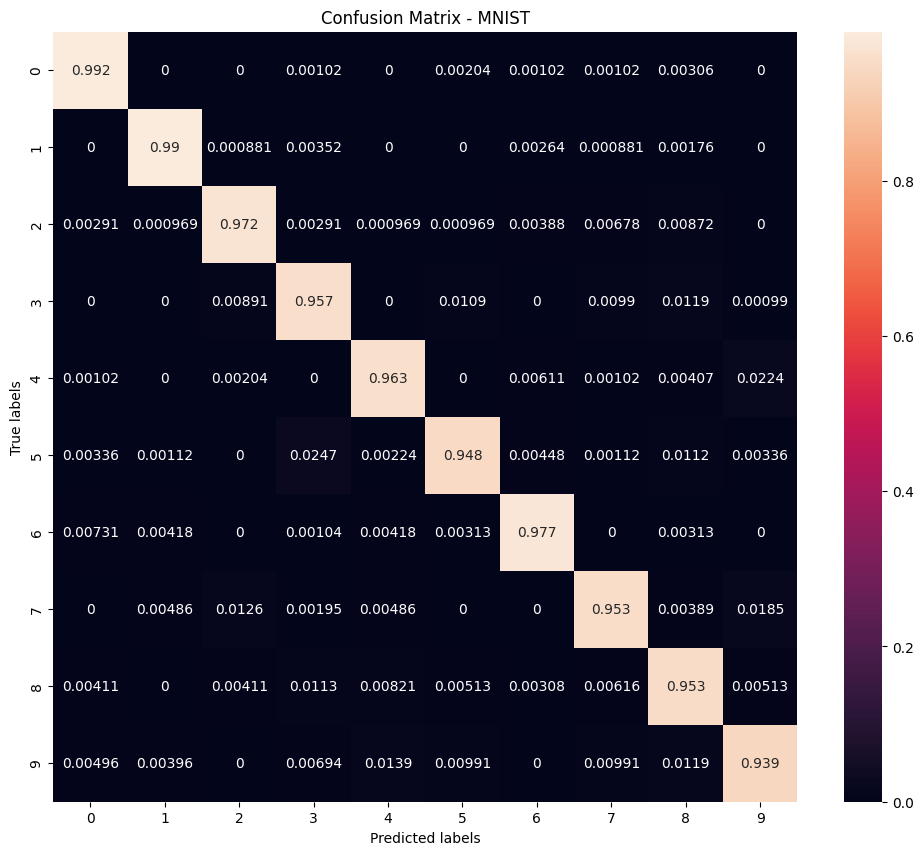

In [ ]:
y_pred = clf1.predict(np.squeeze(test_features))

cm = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt=".3g")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - MNIST')
plt.show()

2


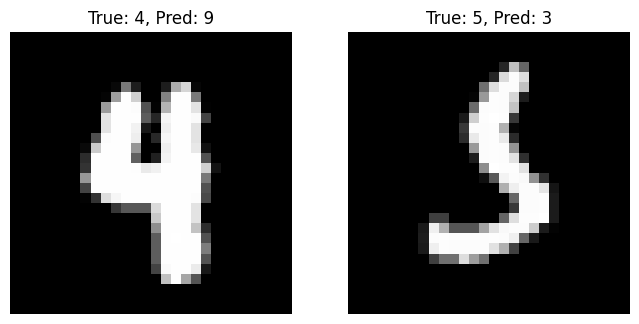

In [ ]:
find_confused_pairs(clf1, x_test, test_features, y_test)

# 2a MNIST

### Part 3

=============================================>c/w Saab Train Hop 1
=============================================>c/w Saab Train Hop 2
=============================================>c/w Saab Train Hop 3
MNIST Pixelhop++ TH1 =  0.0005 TH2 = 0.001
Training Time:  1061.7795932292938
Model Size:  (24, 107, 127)
Train Accuracy:  0.9851166666666666
Test Accuracy:  0.9686
=============================================>c/w Saab Train Hop 1
=============================================>c/w Saab Train Hop 2
=============================================>c/w Saab Train Hop 3
MNIST Pixelhop++ TH1 =  0.001 TH2 = 0.001
Training Time:  1078.898399591446
Model Size:  (24, 107, 127)
Train Accuracy:  0.9851166666666666
Test Accuracy:  0.9686
=============================================>c/w Saab Train Hop 1
=============================================>c/w Saab Train Hop 2
=============================================>c/w Saab Train Hop 3
MNIST Pixelhop++ TH1 =  0.005 TH2 = 0.001
Training Time:  418.3528635

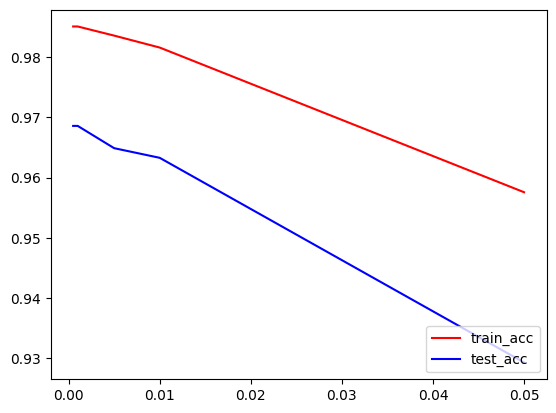

In [21]:
# MNIST, PixelHop++, TH1 variation
TH1_values = [0.0005, 0.001, 0.005, 0.01, 0.05]

train_accuracies = []
test_accuracies = []

for TH1 in TH1_values:
    model_size, _, _, _, _, training_time, train_acc, test_acc = train(dataset='MNIST', isPixelHopPlusPlus=True, TH1=TH1, TH2=0.001, model_size=True)

    print("MNIST Pixelhop++ TH1 = ", TH1, "TH2 = 0.001")

    print("Training Time: ", training_time)

    print("Model Size: ", model_size)

    print("Train Accuracy: ", train_acc)
    train_accuracies.append(train_acc)

    print("Test Accuracy: ", test_acc)
    test_accuracies.append(test_acc)

_, ax = plt.subplots()
ax.plot(TH1_values, train_accuracies, color='r', label='train_acc')
ax.plot(TH1_values, test_accuracies, color='b', label='test_acc')
ax.legend(loc='lower right')
plt.show()

# 2a Fashion MNIST

### Part 1 & 2

In [ ]:
# FashionMNIST, PixelHop++, TH1=0.005, TH2=0.001
pixelhop_parameters_size, clf2, x_test, test_features, y_test, training_time, train_acc, test_acc = train(dataset='FashionMNIST', isPixelHopPlusPlus=True, TH1=0.005, TH2=0.001, model_size=True)

print("FashionMNIST Pixelhop++ TH1 = 0.005, TH2 = 0.001")

print("Training Time: ", training_time)

print('Model Size: ', pixelhop_parameters_size)

print("Train Accuracy: ", train_acc)
print("Test Accuracy: ", test_acc)

4422102/4422102 [==============================] - 0s 0us/step
=============================================>c/w Saab Train Hop 1
=============================================>c/w Saab Train Hop 2
=============================================>c/w Saab Train Hop 3
FashionMNIST Pixelhop++ TH1 = 0.005, TH2 = 0.001
Training Time:  367.13567066192627
Model Size:  (23, 58, 74)
Train Accuracy:  0.9002166666666667
Test Accuracy:  0.85


# 2c

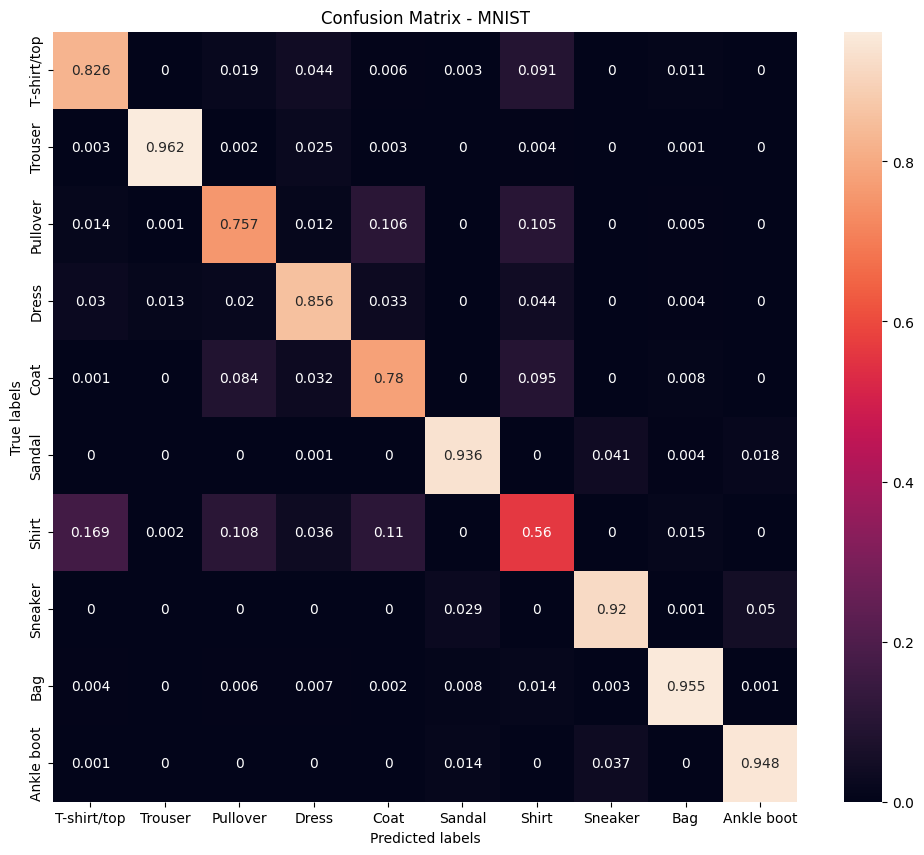

In [ ]:
y_pred = clf2.predict(np.squeeze(test_features))

cm = confusion_matrix(y_test, y_pred, normalize='true')
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt=".3g", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - MNIST')
plt.show()

2


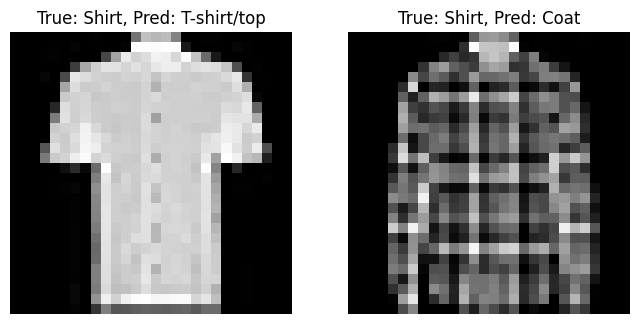

In [ ]:
find_confused_pairs(clf2, x_test, test_features, y_test, class_names)

# 2a FasionMNIST

### Part 3

=============================================>c/w Saab Train Hop 1
=============================================>c/w Saab Train Hop 2
=============================================>c/w Saab Train Hop 3
FashionMNIST Pixelhop++ TH1 =  0.0005 TH2 = 0.001
Training Time:  738.784613609314
Model Size:  (23, 58, 83)
Train Accuracy:  0.9054333333333333
Test Accuracy:  0.8554
=============================================>c/w Saab Train Hop 1
=============================================>c/w Saab Train Hop 2
=============================================>c/w Saab Train Hop 3
FashionMNIST Pixelhop++ TH1 =  0.001 TH2 = 0.001
Training Time:  741.3153293132782
Model Size:  (23, 58, 83)
Train Accuracy:  0.9054333333333333
Test Accuracy:  0.8554
=============================================>c/w Saab Train Hop 1
=============================================>c/w Saab Train Hop 2
=============================================>c/w Saab Train Hop 3
FashionMNIST Pixelhop++ TH1 =  0.005 TH2 = 0.001
Training Tim

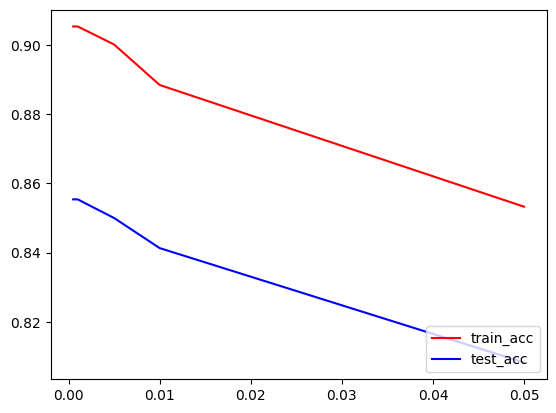

In [23]:
# FashionMNIST, PixelHop++, TH1 variation
TH1_values = [0.0005, 0.001, 0.005, 0.01, 0.05]

train_accuracies = []
test_accuracies = []

for TH1 in TH1_values:
    model_size, _, _, _, _, training_time, train_acc, test_acc = train(dataset='FashionMNIST', isPixelHopPlusPlus=True, TH1=TH1, TH2=0.001, model_size=True)

    print("FashionMNIST Pixelhop++ TH1 = ", TH1, "TH2 = 0.001")

    print("Training Time: ", training_time)

    print("Model Size: ", model_size)

    print("Train Accuracy: ", train_acc)
    train_accuracies.append(train_acc)

    print("Test Accuracy: ", test_acc)
    test_accuracies.append(test_acc)

_, ax = plt.subplots()
ax.plot(TH1_values, train_accuracies, color='r', label='train_acc')
ax.plot(TH1_values, test_accuracies, color='b', label='test_acc')
ax.legend(loc='lower right')
plt.show()

# 2b Comparison

In [ ]:
TH2_values = [0.001, 0.005, 0.01]

train_time = {
    'mnist_pixelhop++': [],
    'fashion_mnist_pixelhop++': [],
    'mnist_pixelhop': [],
    'fashion_mnist_pixelhop': []
}
model_size = {
    'mnist_pixelhop++': [],
    'fashion_mnist_pixelhop++': [],
    'mnist_pixelhop': [],
    'fashion_mnist_pixelhop': []
}
train_accuracies = {
    'mnist_pixelhop++': [],
    'fashion_mnist_pixelhop++': [],
    'mnist_pixelhop': [],
    'fashion_mnist_pixelhop': []
}
test_accuracies = {
    'mnist_pixelhop++': [],
    'fashion_mnist_pixelhop++': [],
    'mnist_pixelhop': [],
    'fashion_mnist_pixelhop': []
}

for TH2 in TH2_values:
    print(TH2)
    pixelhop_parameters_size1, _, _, _, _, train_time1, train_acc1, test_acc1 = train(dataset='MNIST', isPixelHopPlusPlus=True, TH1=0.005, TH2=TH2, model_size=True)
    model_size['mnist_pixelhop++'].append(pixelhop_parameters_size1)
    train_time['mnist_pixelhop++'].append(train_time1)
    train_accuracies['mnist_pixelhop++'].append(train_acc1)
    test_accuracies['mnist_pixelhop++'].append(test_acc1)
    print("MNIST Pixelhop++")

    pixelhop_parameters_size2, _, _, _, _, train_time2, train_acc2, test_acc2 = train(dataset='FashionMNIST', isPixelHopPlusPlus=True, TH1=0.005, TH2=TH2, model_size=True)
    model_size['fashion_mnist_pixelhop++'].append(pixelhop_parameters_size2)
    train_time['fashion_mnist_pixelhop++'].append(train_time2)
    train_accuracies['fashion_mnist_pixelhop++'].append(train_acc2)
    test_accuracies['fashion_mnist_pixelhop++'].append(test_acc2)
    print("FashionMNIST Pixelhop++")

    pixelhop_parameters_size3, _, _, _, _, train_time3, train_acc3, test_acc3 = train(dataset='MNIST', isPixelHopPlusPlus=False, TH1=0.005, TH2=TH2, model_size=True)
    model_size['mnist_pixelhop'].append(pixelhop_parameters_size3)
    train_time['mnist_pixelhop'].append(train_time3)
    train_accuracies['mnist_pixelhop'].append(train_acc3)
    test_accuracies['mnist_pixelhop'].append(test_acc3)
    print("MNIST Pixelhop")

    pixelhop_parameters_size4, _, _, _, _, train_time4, train_acc4, test_acc4 = train(dataset='FashionMNIST', isPixelHopPlusPlus=False, TH1=0.005, TH2=TH2, model_size=True)
    model_size['fashion_mnist_pixelhop'].append(pixelhop_parameters_size4)
    train_time['fashion_mnist_pixelhop'].append(train_time4)
    train_accuracies['fashion_mnist_pixelhop'].append(train_acc4)
    test_accuracies['fashion_mnist_pixelhop'].append(test_acc4)
    print("FashionMNIST Pixelhop")

0.001
=============================================>c/w Saab Train Hop 1
=============================================>c/w Saab Train Hop 2
=============================================>c/w Saab Train Hop 3
MNIST Pixelhop++
=============================================>c/w Saab Train Hop 1
=============================================>c/w Saab Train Hop 2
=============================================>c/w Saab Train Hop 3
FashionMNIST Pixelhop++
=============================================>c/w Saab Train Hop 1
=============================================>c/w Saab Train Hop 2
=============================================>c/w Saab Train Hop 3
MNIST Pixelhop
=============================================>c/w Saab Train Hop 1
=============================================>c/w Saab Train Hop 2
=============================================>c/w Saab Train Hop 3
FashionMNIST Pixelhop
0.005
=============================================>c/w Saab Train Hop 1
=======================================

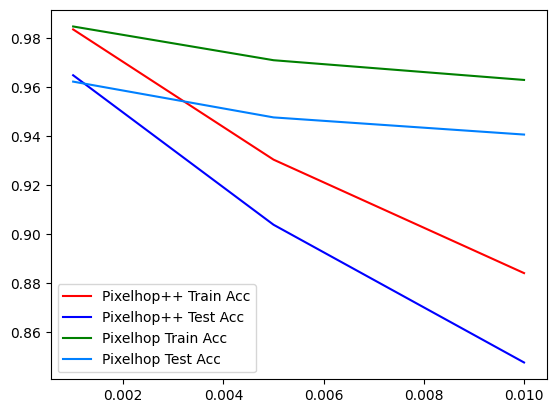

In [ ]:
# MNIST

mnist_pixelhopplusplus_train = train_accuracies['mnist_pixelhop++']
mnist_pixelhopplusplus_test = test_accuracies['mnist_pixelhop++']

mnist_pixelhop_train = train_accuracies['mnist_pixelhop']
mnist_pixelhop_test = test_accuracies['mnist_pixelhop']

_, ax = plt.subplots()
ax.plot(TH2_values, mnist_pixelhopplusplus_train, color='r', label='Pixelhop++ Train Acc')
ax.plot(TH2_values, mnist_pixelhopplusplus_test, color='b', label='Pixelhop++ Test Acc')

ax.plot(TH2_values, mnist_pixelhop_train, color='g', label='Pixelhop Train Acc')
ax.plot(TH2_values, mnist_pixelhop_test, color=(0, 0.5, 1), label='Pixelhop Test Acc')
ax.legend(loc='lower left')
plt.show()

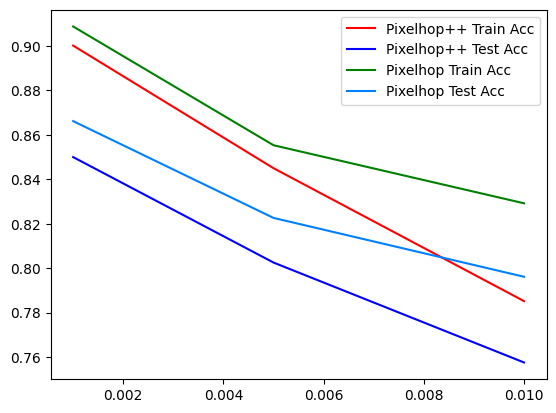

In [ ]:
# FashionMNIST

fashion_mnist_pixelhopplusplus_train = train_accuracies['fashion_mnist_pixelhop++']
fashion_mnist_pixelhopplusplus_test = test_accuracies['fashion_mnist_pixelhop++']

fashion_mnist_pixelhop_train = train_accuracies['fashion_mnist_pixelhop']
fashion_mnist_pixelhop_test = test_accuracies['fashion_mnist_pixelhop']

_, ax = plt.subplots()
ax.plot(TH2_values, fashion_mnist_pixelhopplusplus_train, color='r', label='Pixelhop++ Train Acc')
ax.plot(TH2_values, fashion_mnist_pixelhopplusplus_test, color='b', label='Pixelhop++ Test Acc')

ax.plot(TH2_values, fashion_mnist_pixelhop_train, color='g', label='Pixelhop Train Acc')
ax.plot(TH2_values, fashion_mnist_pixelhop_test, color=(0, 0.5, 1), label='Pixelhop Test Acc')
ax.legend(loc='upper right')
plt.show()

In [ ]:
print(train_time)

{'mnist_pixelhop++': [411.68615984916687, 443.5126814842224, 307.2543685436249], 'fashion_mnist_pixelhop++': [355.8185348510742, 345.5793309211731, 245.5482633113861], 'mnist_pixelhop': [170.69388580322266, 121.91823315620422, 105.9893593788147], 'fashion_mnist_pixelhop': [166.38635730743408, 116.73134446144104, 101.34054851531982]}


In [ ]:
print(model_size)

{'mnist_pixelhop++': [(24, 107, 124), (13, 31, 20), (10, 18, 11)], 'fashion_mnist_pixelhop++': [(23, 58, 74), (12, 19, 21), (9, 11, 12)], 'mnist_pixelhop': [(24, 55, 65), (13, 23, 23), (10, 16, 17)], 'fashion_mnist_pixelhop': [(23, 45, 43), (12, 16, 14), (9, 10, 10)]}
